# Domácí úkol 4
## Popis problému

Uvažujte model hromadné obsluhy $M|G|\infty$.

* Požadavky přichází podle Poissonova procesu s intenzitou $\lambda = 10~\mathrm{s}^{-1}$.
* Doba obsluhy jednoho požadavku (v sekundách) má rozdělení $S\sim\mathrm{Ga}(4,2)$, tj. Gamma s parametry $a = 4$, $p = 2$.
* Časy mezi příchody a časy obsluhy jsou nezávislé.
* Systém má (teoreticky) nekonečně paralelních obslužných míst (každý příchozí je rovnou obsluhován).

Označme $N_t$ počet zákazníků v systému v čase $t$. Předpokládejme, že na začátku je systém prázdný, tj. $N_0 = 0$.

## 1. Simulujte jednu trajektorii $N_t(\omega) \mid t\in(0,10~\mathrm{s})$. Průběh trajektorie graficky znázorněte.

Jelikož požadavky přichází podle Poissonova procesu $\text{Poisson}(\lambda)$, tak si nejprve vygenerujeme pomocí numpy funkce počet zákazníků, kteří by mohli přijít v zadaném časovém intervalu. Tuto hodnotu označme $n$.

Víme-li, že během intervalu $(0, 10)$ přišlo právě $n$ zákazníků, pak podmíněné rozdělení časů příchodu Poissonova procesu je stejné, jako by si těchto $n$ zákazníků vybralo čas příchodu rovnoměrně (víme z přednášky). Proto si s pomocí rovnoměrného rozdělení $\text{Unif}(0, 10)$ vygenerujeme $n$ časů příchodu zákazníků. Časy odchodu zákazníků získáme pro každého zákazníka tak, že k jeho času příchodu přičteme hodnotu získanou z Gamma rozdělení se zadanými parametry. Obě skupiny časů seřadíme vzestupně a napočítáme počty zákazníků v závislosti na čase.

Výsledné časy a počty zákazníků je pak možné pozorovat na grafu níže (graf jedné možné trajektorie).

In [109]:
import matplotlib.pyplot as plt
import numpy as np
import math

plt.rcParams['figure.figsize'] = [15, 8]
plt.style.use('seaborn-darkgrid')
rng = np.random.default_rng()

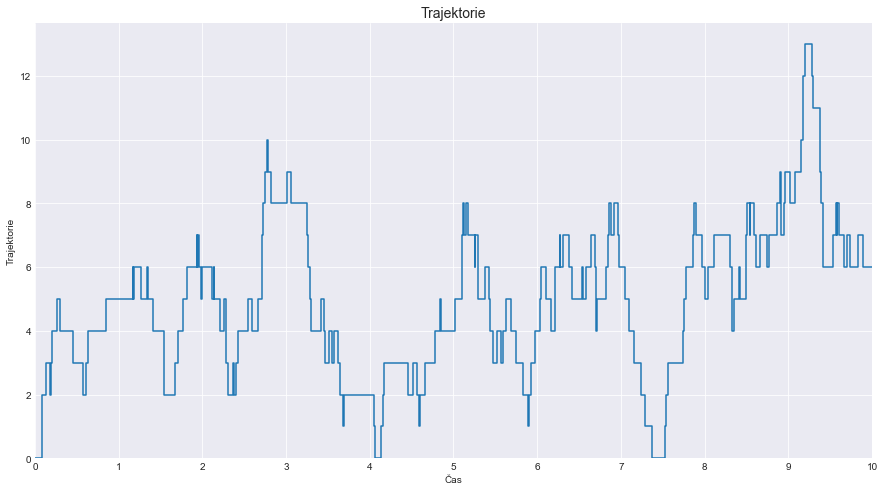

In [110]:
def plot_trajectory(customers: list[tuple[float, int]], time: int):
    plt.xlabel('Čas')
    plt.ylabel('Trajektorie')
    plt.step([c[0] for c in customers], [c[1] for c in customers], where='post')
    plt.xticks(range(0, time + 1))
    plt.xlim(0, time)
    plt.ylim(0)
    plt.title('Trajektorie', fontsize=14)
    plt.show()


def simulate_trajectory(lam: int, a: int, p: int, time: int, plot: bool = True):
    n = rng.poisson(lam * time)
    arrival_times = rng.uniform(0, time, n)
    arrival_times.sort()

    gamma_d = rng.gamma(p, 1 / a, n)
    depart_times = arrival_times + gamma_d
    depart_times.sort()

    customers = [(0.0, 0)]
    c_count = 0

    arr_i = 0
    dep_i = 0
    while arr_i < n or dep_i < n:
        if arr_i < n and dep_i < n:
            if arrival_times[arr_i] < depart_times[dep_i]:
                c_count += 1
                customers.append((arrival_times[arr_i], c_count))
                arr_i += 1
            elif arrival_times[arr_i] > depart_times[dep_i]:
                c_count -= 1
                customers.append((depart_times[dep_i], c_count))
                dep_i += 1
            else:
                arr_i += 1
                dep_i += 1
        elif arr_i < n:
            c_count += 1
            customers.append((arrival_times[arr_i], c_count))
            arr_i += 1
        else:
            c_count -= 1
            customers.append((depart_times[dep_i], c_count))
            dep_i += 1

    if plot:
        plot_trajectory(customers, time)

    return customers


_ = simulate_trajectory(10, 4, 2, 10)

## 2. Simulujte $n = 500$ nezávislých trajektorií pro $t\in(0,100)$. Na základě těchto simulací odhadněte rozdělení náhodné veličiny $N_{100}$.

Simulace trajektorií probíhá stejně jako je popsáno výše s rozdílem, že se nyní jedná o časový interval $(0,100)$.

Z celé simulace nás však nyní zajímá pouze počet zákazníků v čase $t = 100$ (pro 500 simulací). Rozdělení počtu zákazníků je znázorněno pomocí histogramu níže.

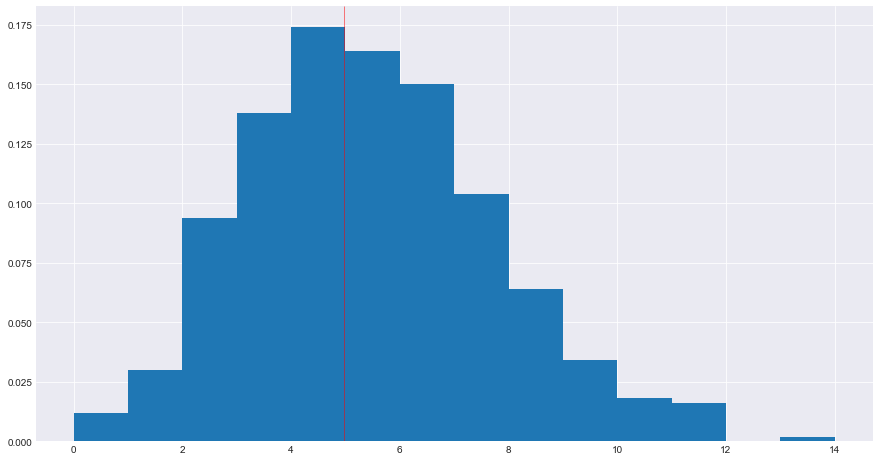

Výběrový průměr: 4.978 , výběrový rozptyl: 5.225516


In [111]:
def get_customer_count(customers: list[tuple[float, int]], time: float):
    for i, tup in enumerate(customers):
        if tup[0] > time:
            return customers[i - 1][1]

    return 0


N = 500
time = 100
n_100 = [get_customer_count(simulate_trajectory(10, 4, 2, time, False), time) for _ in range(N)]

n_100_mean = np.mean(n_100)
n_100_var = np.var(n_100)

plt.hist(n_100, bins=max(n_100), density=True)
# Highlight mean value
plt.axvspan(xmin=n_100_mean, xmax=n_100_mean, color='red', alpha=0.5)
plt.show()

print('Výběrový průměr: {} , výběrový rozptyl: {}'.format(n_100_mean, n_100_var))

### Porovnání výsledku s Poissonovým rozdělením v grafu

Jelikož zákazníci přichází podle Poissonova rozdělení, tak i počet zákazníků v čase $t = 100$ by měl mít Poissonovo rozdělení. Toto tvrzení se pokusíme potvrdit pomocí porovnání histogramů získaného rozdělení (modře) a Poissonova rozdělení (oranžově).

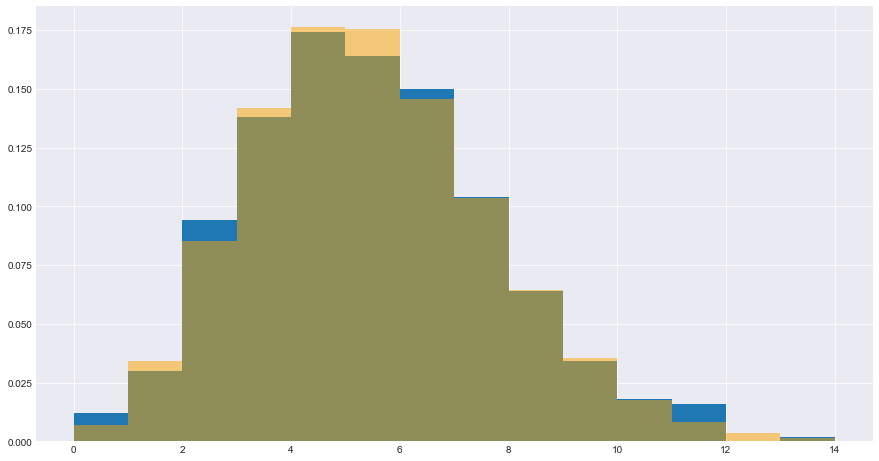

In [112]:
def poisson(l, k):
    return ((l ** k) * (math.e ** -l)) / math.factorial(k)


_ = plt.hist(n_100, bins=max(n_100), density=True)
_ = plt.bar(range(max(n_100)), [poisson(n_100_mean, k) for k in range(max(n_100))], width=1, alpha=0.5, align='edge',
            color='orange')

Je vidět, že oba histogramy jsou si velice podobné.

## 3. Diskutujte, jaké je limitní rozdělení tohoto systému pro $t\to+\infty$ (vizte [*přednášku 23*](https://courses.fit.cvut.cz/NI-VSM/lectures/files/NI-VSM-Lec-23-Slides.pdf).). Pomocí vhodného testu otestujte na hladině významnosti $5~\%$, zda výsledky simulace $N_{100}$ odpovídají tomuto rozdělení.

Tento bod úkoly jsme se rozhodli již vynechat.